# History Match Freyberg using K

In this notebook we will start to ease our way into using PEST++ for history-matching and uncertainty analysis. We will start by revisting the Freyberg model and the PEST control file. Both of these are pre-prepared and provided for you. We will calibrate the model by adjusting a single hydraulic property (hydraulic conductivity) and then look at typical summary statstics and plots that describe our degree of fit. 

We will also start to gently introduce the use of `pyEMU` and programaticaly interfacing with PEST and PEST outputs. 

### Admin

We have provided some pre-cooked PEST dataset files, wraped around the modified Freyberg model. This is the same dataset introduced in the "freyberg pest setup" notebook. 

The functions in the next cell import required dependencies and prepare a folder for you. This folder contains the model files and a preliminary PEST setup. Run the cells, then inspect the new folder named "freyberg_k" which has been created in your tutorial directory. (Just press `shift+enter` to run the cells). 

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import shutil

sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd



c:\Users\rui2h\.conda\envs\gmdsitut\lib\site-packages\nbconvert\exporters\html.py:110: DeprecationWarning: 'contextfilter' is renamed to 'pass_context', the old name will be removed in Jinja 3.1.


In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')

# a dir to hold a copy of the org model files
tmp_d = os.path.join('freyberg_mf6')

if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)


# get executables
hbd.prep_bins(tmp_d)
# get dependency folders
hbd.prep_deps(tmp_d)
# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(tmp_d)

ins file for heads.csv prepared.
ins file for sfr.csv prepared.
noptmax:0, npar_adj:1, nnz_obs:24
written pest control file: freyberg_mf6\freyberg.pst


### Reminder - the modified-Freyberg model
Just a quick reminder of what the model looks like and what we are doing. 

It is a one-layer model. A river runs north-south, represented with the SFR package (green cells in the figure). On the southern border there is a GHB (cyan cells). No-flow cells are shown in black. Pumping wells are shown with red cells. 

Time-series of measured heads are available at the locations marked with black X's. River flux is also measured at three locations (headwater, tailwater and gage; not displayed).

The simulation starts with a steady state stress period, followed by twelve transient stress periods. These represent the historic period, for which measured data are available.

A subsequent twelve transient stress periods representing a period in the future. Modelling is undertaken to assess selected forecasts during the simulated period.

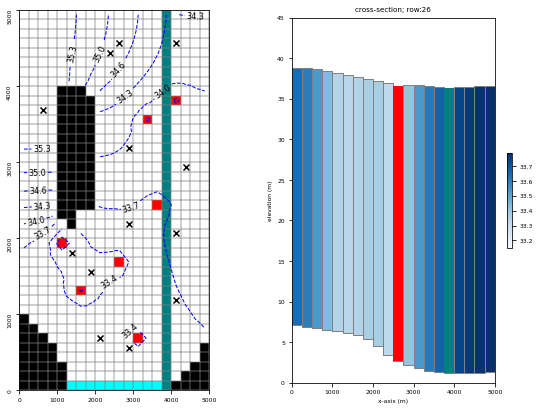

In [3]:
hbd.plot_freyberg(tmp_d)

### The PEST Control File

Open the new folder named `freyberg_k` and find the file named `freyberg.pst`. Open it in a text editor. You may recognize it from the previous tutorial.

In the tutorial folder there is a PDF file named "Annotated_PEST_control_file_SIR20105169.pdf". Open it up and use it to guide you through reading the PEST control file and answering the following questions:

1. How many parameters are we running? 
2. How many are adjustable? 
3. How many types of observations are included?
4. How many forecasts? What types?
5. How many template (tpl) files do we have?
6. How many instruction (ins) files do we have? 

Here's an annotated top of the PEST control file. Check the variables highlighted in yellow to answer the above questions:

<img src="figs\2010-5169_annotated_Appendix1_PST_file.png" style="float: center">

Now, as we did in the previous tutorial, let's double check these files to make sure the PEST dataset does not have any errors. Run TEMPCHEK, INSCHEK and PESTCHEK on the template, instruction and control files respectively.

To speed things up, this time, instead of running them in a separate terminal window we can run them directly from this notebook using `pyemu`. Execute the next code block then look at the terminal window from which you launched this notebook.

In [4]:
# use pyemu to run a command line, run tempchek on the tpl files listed in the control file
pyemu.os_utils.run("tempchek freyberg6.npf_k_layer1.tpl", # the instruction passed to the command line
                    cwd=tmp_d)                            # the directory in which the command is executed

**Do it yourself for the other TPL files:**

In [5]:
#pyemu.os_utils.run("tempchek ....", cwd=tmp_d)  

Now check the instruction files with `INSCHEK`:

In [6]:
# use pyemu to run a command line, run inschek on the ins files listed in the control file
pyemu.os_utils.run("inschek heads.csv.ins heads.csv", cwd=tmp_d)

**Do it yourself for the other INS files:**

In [7]:
#pyemu.os_utils.run("tempchek ....", cwd=tmp_d)  

And of course, check the control file with `PESTCHEK`:

In [8]:
# use pyemu to run a command line, run pestchek on the pst file 
pyemu.os_utils.run("pestchek freyberg.pst", cwd=tmp_d)

### Run PEST

Okay, let's run this thing. 

Because we call a program from within the Jupyter Notebook you have to look at the terminal window that you used to start the notebook to see the screen report of the run.  So, when executing this next block look at your terminal window to see the run.  It will say "Simulation complete..." when finished.

> Note: And/or wait until the standard out reports a "0" below this next block (=when the run is finished) before going on.

In [9]:
# use pyemu to run a command line, run pestpp on the pst file defined on the import
pyemu.os_utils.run("pestpp-glm freyberg.pst", cwd=tmp_d)

``PEST++`` only ran the model one time - why?

Yeah, that's right, the NOPTMAX=0 thing again.  We had that set to zero because we want to check the plumbing before burning the silicon. Did everything run (i.e., did you see "Simulation Complete..." in your terminal window?  Like before, you *could* change NOPTMAX to 20 in a text editor.  But, `pyemu` can do it for you with the next block.  

> Note: see the "intro to pyemu" tutorial notebook for an overview of `pyemu`.

In [10]:
# specify the path ot the pst control file
pstfile = os.path.join(tmp_d,'freyberg.pst')

# pymu stores all things related to a PEST control file in the Pst class. 
# We can instantiate a Pst object by reading an existing control file 
pst = pyemu.Pst(pstfile)

# We can access and modfiy variables in the "* control data" section using the Pst.control_data attribute
# have pyemu change PEST's NOPTMAX variable to 20
pst.control_data.noptmax = 20

# changes so far are only stored in memory, they have not been written to the .pst control file yet
# Easy enough to accomplish - write out a new pst control file
pst.write(pstfile)

noptmax:20, npar_adj:1, nnz_obs:24


Check the `freyberg.pst` file again in a text editor. Verify that NOPTMAX has been changed to 20?

Great, let's try that again!

Just like before  you have to look at the terminal window that you used to start the notebook to see the screen report of the run.  So, when executing this next block look at your terminal window to see the run.  It will say "Simulation complete..." when finished. It should take a couple of minutes.

Or wait until the standard out  reports a "0" below this next block (=when the run is finished) before going on.

In [11]:
# use pyemu to run a command line, run pest++ on the pst file defined above
pyemu.os_utils.run("pestpp-glm freyberg.pst", cwd=tmp_d)

### Explore Results

PEST writes lots of usefull information to the `*.rec` file. It also outputs a series of other useful files. What outputs are recorded depends on which version of PEST or PEST++ is being used. Here we will use PEST++GLM. The following section will demonstrate usefull information that can be found in some of the outputs. Throughout subsequent tutorials we will address others.

#### Objective Function
First let's look at the measurement objective function (Phi), which is calculated using the sum of squared weighted residuals.  First we'll look at a table, then plots.

In [12]:
# make a dataframe "df_obj" that shows the contents of the pst file casename with the extension .iobj
# .iobj = PEST++ output file that has the objective function by iteration 
df_obj = pd.read_csv(os.path.join(tmp_d, "freyberg.iobj"),index_col=0)
# echo out the dataframe
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,gage-1,headwater,tailwater,trgw-0-13-10,trgw-0-15-16,trgw-0-2-15,trgw-0-2-9,trgw-0-21-10,trgw-0-22-15,trgw-0-24-4,trgw-0-26-6,trgw-0-29-15,trgw-0-3-8,trgw-0-33-7,trgw-0-34-10,trgw-0-9-1
iteration,,,,,,,,,,,,,,,,,,,,
0,0,29.20310,29.20310,0,0,0,0,0,0,0,0,0,0,0,18.35720,0,10.845900,0,0,0
1,12,3.43666,3.43666,0,0,0,0,0,0,0,0,0,0,0,2.46626,0,0.970404,0,0,0
2,23,3.41691,3.41691,0,0,0,0,0,0,0,0,0,0,0,2.35484,0,1.062070,0,0,0
3,35,3.40901,3.40901,0,0,0,0,0,0,0,0,0,0,0,2.21763,0,1.191380,0,0,0


So thats usefull. If we make a plot (see next cell), it becomes evident that there are diminshing returns after a certain point (for this case!).

array([<AxesSubplot:xlabel='iteration'>, <AxesSubplot:xlabel='iteration'>],
      dtype=object)

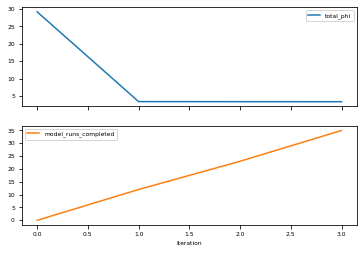

In [13]:
# plot out the dataframe that was shown as a table above
df_obj.loc[:,["total_phi","model_runs_completed"]].plot(subplots=True)

**Termination Criteria** 

But hold on a second! We told PEST to try 20 parameter estimation upgrades but it stopped at 8!  What gives?!?

>hint: search the `.rec` file for OPTIMIZATION COMPLETE

PEST and PEST++ will quit the parameter estimation process if one of these 4 conditions is met:

1. The maximum number of interations specified in NOPTMAX is reached
2. The fit is not getting any better based on a user-supplied closure
3. The parameters are not changing based on a user-supplied closure
4. The user halted the run, usually with a ctrl-c  (happens quite frequently)

**Final Phi** 

Look at the FINAL OPTIMISATION RESULTS in the terminal where PEST++ ran (you can also find it near the bottom of the `.rec` file).  

Which target group(s) matter?  How was splitting the contributions to PHI accomplished in the PEST control file?

For this problem, recall our objective function is calculated using this equation:

<img src="figs\SOSWR_eq_AW&H2015.png" style="float: center">

where Phi is the "sum of squared weighted residuals" that we look to minimize, *whi* is the weight for the ith head observation; *hm* is the measured (observed) head target; *hs* is the simulated head; and n is the number of observations.  

If we use only heads for calibration, then PHI only reflects the sum of squared weighted residuals for the observed-simulated head targets. 

So! We have two types of observations (heads and flux) each in their respecive observation groups (hds and flux)...but only heads are contributing to the objective function. This is because all "flux" observations have been assigned zero weight (see the `* observation data` section). They are in the control file, but they aren't doing anything for the time-being. 

#### Residuals

Let's evaulate our fit using the observed-simulated residuals.

PEST++ stores obsevration residuals in a `*.rei` file. In the working folder you will find a file named `freyberg.rei`. Open it in a text editor. Here you will find a table with observation names, their measured and simulated values, the differneces between them (e.g. the residuals) and weights assigned in the PEST control file. 

When instantiating a `Pst` class from an existing control file, `pyemu` will attemp to read a corresponding `*.rei` file. Data from the rei file is stored in the `Pst.res` attribute as a `Pandas` `DataFrame`. This makes it easy to access and postprocess. 

In [14]:
# define res_nz to equal a table of residuals for all observations with non-zero weight
# pst.res stores information that is in the .rei file (see the freyberg.rei file in the tutorial folder)
# pst.nnz_obs_names returns a list of all the "non-zero weighted observation names"
res_nz = pst.res.loc[pst.nnz_obs_names,:]
# display res_nz to understand what we are doing
res_nz.head()

,name,group,measured,modelled,residual,weight
name,,,,,,
trgw-0-26-6:3683.5,trgw-0-26-6:3683.5,trgw-0-26-6,37.168420,36.769327,0.399093,1.0
trgw-0-26-6:3712.5,trgw-0-26-6:3712.5,trgw-0-26-6,37.116489,36.804511,0.311978,1.0
trgw-0-26-6:3743.5,trgw-0-26-6:3743.5,trgw-0-26-6,37.182890,36.913996,0.268894,1.0
trgw-0-26-6:3773.5,trgw-0-26-6:3773.5,trgw-0-26-6,37.283326,37.034004,0.249322,1.0
trgw-0-26-6:3804.5,trgw-0-26-6:3804.5,trgw-0-26-6,37.274371,37.113414,0.160957,1.0


We could plot these results up using common libraries. Or, use `pyemu`s built in plotting methods (see next cell).

Not too shabby!  Thanks PEST++.

These plots you'll see a lot.  The left plot is a "1:1" plot that has simulated on the x-axis and observed on the y-axis; a perfect fit would be all circles on the black diagonal line.  The right plot has the residual (y-axis) compared to the observation magnitude (x-axis).  The closer the circle is to the black line the better the fit.  The mean residual is shown as a red line.

<Figure size 576x756 with 0 Axes>

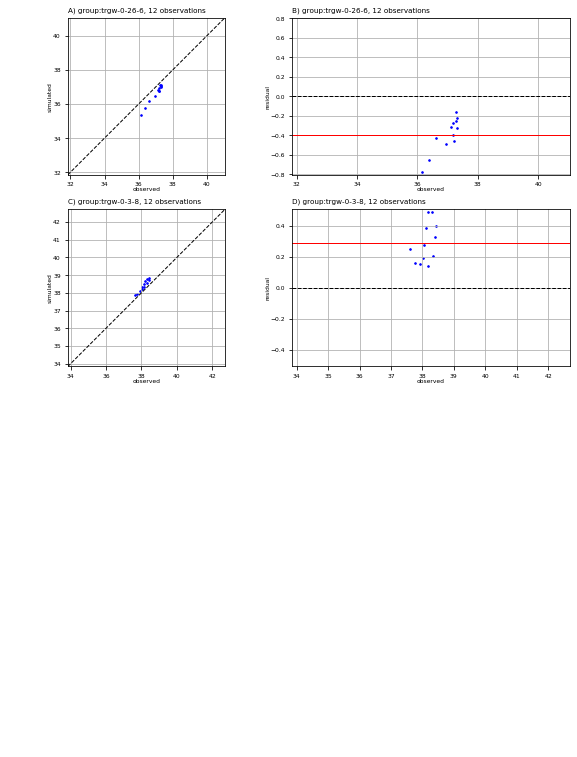

In [15]:
# use pyemu's plot utilities to plot 1:1 line and the residuals as fxn of observation magnitude
pyemu.plot_utils.res_1to1(pst);

But we had a lot of other observations listed in the PEST control file.  What do they look like?

> **Note**: We have used a naming convention for our observations. Each observation name starts with the site name (e.g. "gage-1"), followed by " : " and then the simulation time in days (e.g. "1.0"). So, "gage_1:1.0" refers to the observation at "gage-1" after "1.0" days (in this case, at the end of the first steady state stress period).

How well did the model do at fitting river flux? Recall that only head observations have non-negative weights, so PEST was only interested in getting a good fit with heads, ignoring all other observations.

In [16]:
pst.res.head()

,name,group,measured,modelled,residual,weight
name,,,,,,
gage-1:3652.5,gage-1:3652.5,gage-1,2943.238710,2664.732233,278.506477,0.0
gage-1:3683.5,gage-1:3683.5,gage-1,2815.377509,2481.352657,334.024852,0.0
gage-1:3712.5,gage-1:3712.5,gage-1,2749.121657,2601.435926,147.685731,0.0
gage-1:3743.5,gage-1:3743.5,gage-1,2816.797640,2821.353726,-4.556086,0.0
gage-1:3773.5,gage-1:3773.5,gage-1,2892.313705,3001.715907,-109.402202,0.0


###  Uncertainty Reduction

Now, let's look at what calibration has done for uncertainty reduction. First, let's look the change in uncertainty for horizontal hydraulic conductivity (`hk`) parameters.

PEST++GLM conveniently records parameter and forecast uncertainty summaries in CSV files (we will get to what this means and how it is done in another tutorial). Parameter uncertainty is recorded in the file named `freyberg.par.usum.csv`. 

In [17]:
# define a dataframe that has uses the PEST++ output file freyberg_un.par.usum.csv
# freyberg_un.par.usum.csv is comma-delimited file that has the uncertainty summary for the parameters
df_paru = pd.read_csv(os.path.join(tmp_d, "freyberg.par.usum.csv"),index_col=0)

# echo out this dataframe 
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
hk1,0.69897,1,-1.30103,2.69897,0.505884,0.029466,0.446952,0.564816


Recall that because we log transformed the `hk` parameters the uncertainty results are reported as logarithms in the dataframe above.  What you'll see in the MODFLOW input file is the non-log transformed `hk` value (e.g. 10^0.69897 = 5.0  for the prior mean).

A quick way to evaluate the ***reduction in uncertainty*** is to compare `prior_stdev` (e.g. standard deviation of the prior, or standard deviation before calibration) to `post_stdev` (e.g. standard deviation of the posterior, or standard deviation after caibration).  The amount that `post_stdev` is less than `pre_stdev` reflects the magnitude of the uncertainty reduction

Now let's plot it using `pyemu`'s plot utility.

The dotted gray line represents the "prior" information as expressed by the parameter bounds in the PEST control file. (In this case, the differences between parameter bounds are taken to represent the probability distribution range.) The shaded area is the uncertainty after the calibration.

Wow! Amazing, almost no posterior uncertainty...ermm...yeah, no. That ain't right.

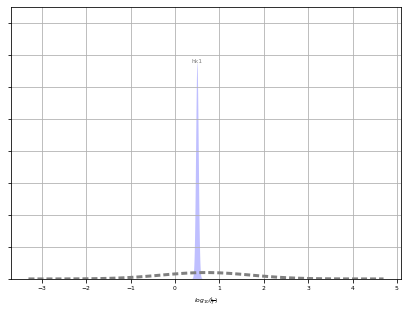

In [18]:
# define a set of plots called ax to have the information of our dataframe df_paru above
ax = pyemu.plot_utils.plot_summary_distributions(df_paru, label_post=True, figsize=(7,5))

# Plot it with a label 
ax.set_xlabel("$log_{10}(\\frac{L}{T})$");

Now let's look at changes in model forecast uncertainty, first as a table then as a plot.  These are *observations* now instead of parameters like above. PEST++GLM has recorded these in the file named `freyberg.pred.usum.csv`.

In [19]:
# define a dataframe that has uses the PEST++ output file freyberg.pred.usum.csv
# freyberg.pred.usum.csv is comma-delimited file that has the uncertainty summary for the predictions 
df_predu = pd.read_csv(os.path.join(tmp_d, "freyberg.pred.usum.csv"),index_col=0)

# echo out the dataframe
df_predu

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
headwater:4383.5,-397.5550,322.0680,-1041.6900,246.5800,-469.1600,9.490010,-488.1400,-450.1800
tailwater:4383.5,-90.2950,381.9170,-854.1290,673.5390,-165.2550,11.253500,-187.7620,-142.7480
trgw-0-9-1:4383.5,38.0999,13.3587,11.3824,64.8173,40.4225,0.393627,39.6352,41.2098


Same deal as above: a quick way to evaluate the ***reduction in uncertainty*** is to compare `prior_stdev` (=standard deviation of the prior=standard deviation before calibration) to `post_stdev` (=standard deviation of the posterior = standard deviation after caibration).  The amount that `post_stdev` is less than pre_stdev reflects the magnitude of the uncertainty reduction.

As we can see in the plot below, prediction uncertainty is reduced for all forecasts. Some by quite a lot! Our calibration must have been amazing (#sarcasm)

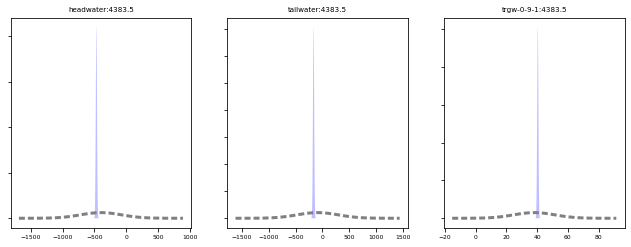

In [20]:
# use the pyemu plotting utility to plot up the forecasts
figs, axes = pyemu.plot_utils.plot_summary_distributions(df_predu,subplots=True)

By comparing prior to posterior standatd deviations we can check how well calibration reduced forecast uncertainties (see bar plot in the next cell; larger value is better).

Text(0, 0.5, '% uncertainty reduction')

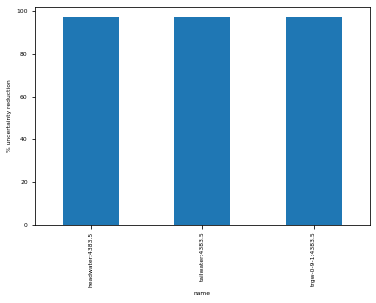

In [21]:
df_predu.loc[:,"percent_reduction"] = 100.0 * (1.0 - (df_predu.post_stdev / df_predu.prior_stdev))
df_predu.percent_reduction.plot.bar()
plt.ylabel('% uncertainty reduction')


Wow! Calibration really helped huh? So we can call it a day and bill the client? Awesome, thanks very much and have a nice day!

Well, no...

Just because we can, let's look again at forecast uncertainty with the "truth". In the next cell we plot the forecast probability distributions again, but this time we have included the "true" outcome as well (the vertical black dashed line). Recal that here we know the "truth" because we (the authors) created reality; in the real-world we do not have this luxury.

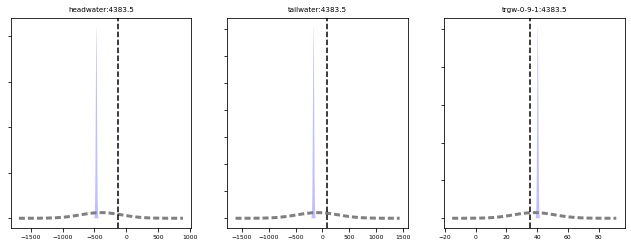

In [22]:
figs, axes = pyemu.plot_utils.plot_summary_distributions(df_predu,subplots=True)
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"k--")
    ax.set_ylim(ylim)

Dear oh dear....none of the forecasts are bracketed by the posterior distribution! This means that 

__uncertainty analysis has failed!__

In some cases the prior (the dashed grey line) encompasses the "truth" but the posterior (the blue shaded area) does not. Therefore calibration actualy made our forecasts less reliable. Why is that? How can improving a model's ability to represent the past make it *worse* at representing the future? 

Find out in the next episode! 